# Using a pretrained Swim Vision Transformer to diagnose Alzheimer's disease from a 2D slice of an MRI scan
We are going to build our vision transformer using PyTorch, so we will need to import the library and some other important packages.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import timm
import os
import matplotlib.pyplot as plt

/opt/anaconda3/envs/huggingface_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set device we are working with
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Define our transformations for MRI images to resize, normalize and convert them to tensors
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [4]:
# Load dataset
data_dir = "./MRI"
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "test"), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [5]:
# Load pretrained Swin Transformer model
model = timm.create_model("swin_tiny_patch4_window7_224", pretrained=True, num_classes=2)
model = model.to(device)

In [6]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

In [13]:
# Training function
train_accuracies = []
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        accuracy = correct / total
        train_accuracies.append(accuracy)
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.4f}")


In [14]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    print(f"Test Accuracy: {correct/total:.4f}")


In [15]:
# Train and evaluate
train_model(model, train_loader, criterion, optimizer, epochs=5)
evaluate_model(model, test_loader)

Epoch 1, Loss: 0.1259, Accuracy: 0.9541
Epoch 2, Loss: 0.0662, Accuracy: 0.9755
Epoch 3, Loss: 0.0754, Accuracy: 0.9709
Epoch 4, Loss: 0.0334, Accuracy: 0.9939
Epoch 5, Loss: 0.0903, Accuracy: 0.9663
Test Accuracy: 0.9109


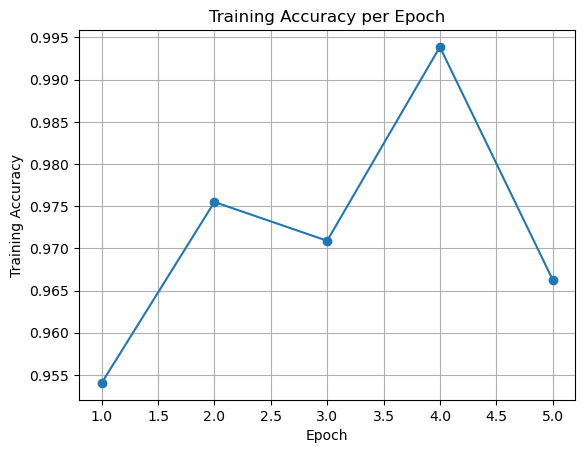

In [16]:
# Plot training accuracy
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy per Epoch')
plt.grid()
plt.show()